In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import time 
import pandas as pd


import progressbar
from progressbar import FormatLabel, Percentage, Bar, ETA


from data_loader import DataLoader
#import viewer functions
from dataViewer import plotTraj, animatePreview, animateLoc, animateTraj


%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
dtype = torch.float
#device = torch.device("cpu")
device = torch.device("cuda:0") # Uncomment this to run on GPU


number_nei = 7


# N is batch size (number of datasets); D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
D_in, H, D_out =  (number_nei+1)*4, 10, 2 #1550

l_o = D_in


learning_rate = 1e-4

iterations = 2

mode = "wrap"



In [3]:
FPS = 16

BG = "Datasets/UG/ug.png"

PATH_1 = "Datasets/UG/UG-roh_nachkorrigiert/ug-100-045.txt"

#PATH_1 = "test.hd5"
#PATH_1 = "test.csv"

#ds = DataLoader(PATH_1)

PATH = "Datasets/AO/"
PATH2 = "data/CSV/"
fname = "ao-360-400_combine"

#PATH_1 = "test.hd5"
#PATH_1 = "test.csv"

#ds = DataLoader(PATH + fname + ".txt")
#ds = DataLoader(PATH2 + fname + ".csv")
ds = DataLoader(PATH + fname + ".txt")

ds.load()

print("Persons: ", ds.data.p.max())
print("Frame maximum :", ds.data.f.max() )

f_x = ds.flip_x
train, val, test = ds.get_train_data(number_nei, augmentation=[f_x], shuffle=False, mode=mode)


N/A% (0 of 350) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

loaded 350 persons
Persons:  350
Frame maximum : 821


100% (350 of 350) |######################| Elapsed Time: 0:02:17 Time:  0:02:17


loaded 350 trajectories
with augmentation 700 trajectories
extracted 212886 steps


In [4]:
t_input, t_truth = train

In [5]:
t_i = torch.from_numpy(t_input).to(device)
t_t = torch.from_numpy(t_truth).to(device)


# A batch is in shape [batches, sequences, sequence length, features]  
x=torch.Size([128, 30, 12, 45])
y=torch.Size([128, 30, 1, 1])

#t_i = t_i.view(1, -1, 1 , D_in)
#t_t = t_t.view(1, -1, 1, D_out)

In [6]:
#x_batches, x_seqs, x_seq_len, x_features = t_i.shape

# Define Model

In [7]:

#define network
"""model = torch.nn.Sequential(
    
    torch.nn.Linear(D_in, H), 
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    
    torch.nn.ReLU(),
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    
    torch.nn.Dropout(p=0.2),
    
    torch.nn.Linear(H, H),
    
    torch.nn.ReLU(),
    
    torch.nn.Linear(H, H),
    torch.nn.ReLU(),
    
    torch.nn.Linear(H, D_out)
    
    
    
)"""


model = torch.nn.Sequential(
    
    torch.nn.Linear(D_in, 50), 
    torch.nn.ReLU(),
    torch.nn.Linear(50, 10),
    
    torch.nn.ReLU(),
    torch.nn.Linear(10, 50),
    torch.nn.ReLU(),
    
    torch.nn.Dropout(p=0.1),
    
    torch.nn.Linear(50, 30),
    
    torch.nn.ReLU(),
    
    torch.nn.Dropout(p=0.1),
    
    torch.nn.Linear(30, D_out),
    
    
    
)



#model = Model()

if device.type.startswith("cuda"):
    model.cuda()

In [8]:
#choose loss function - can be played around with
loss_fn = torch.nn.MSELoss(reduction='mean')


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



In [9]:

d_len = t_i.shape[0]


pbar = progressbar.ProgressBar(max_value=iterations)

widgets = [FormatLabel(''), ' ', Percentage(), ' ', Bar(), ' ', ETA()]
pbar = progressbar.ProgressBar(widgets=widgets, maxval=iterations*d_len)
pbar.start()

for t in range(iterations):
    # Forward pass: compute predicted y using operations on Tensors; these
    # are exactly the same operations we used to compute the forward pass using
    # Tensors, but we do not need to keep references to intermediate values since
    # we are not implementing the backward pass by hand.
    for  y, (t_i_b, t_t_b) in  enumerate(zip(t_i, t_t)):
        y_pred = model(t_i_b)


        """if t==1000:
            lr = 1e-5
            #optimizer.lr = lr
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
        if t==4000:
            lr = 1e-6
            #optimizer.lr = lr
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr"""

        # Compute and print loss using operations on Tensors.
        # Now loss is a Tensor of shape (1,)
        # loss.item() gets the scalar value held in the loss.
        loss = loss_fn(y_pred, t_t_b)
        #if t % 10 == 9:
        widgets[0] = FormatLabel('loss: {:.4} | lr:{:.2}'.format(loss.item(), optimizer.param_groups[0]['lr']))
            #print(t, loss.item())


        model.zero_grad()
        # Use autograd to compute the backward pass. This call will compute the
        # gradient of loss with respect to all Tensors with requires_grad=True.
        # After this call w1.grad and w2.grad will be Tensors holding the gradient
        # of the loss with respect to w1 and w2 respectively.
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()
        pbar.update(t*d_len+y)

pbar.finish()






loss: 1.125e+03 | lr:0.0001  17% |#####                        | ETA:   0:13:29

KeyboardInterrupt: 

In [10]:

frame, traj = ds.person(1)

da = DataLoader(None)

da.copy(ds)

print(da.persons)

#for i in range(3, da.persons+1):
#    da.remove_person(i)


350


In [11]:
optimizer.param_groups[0]['lr']

0.0001

In [38]:
class Agent():
    def __init__(self, model, pos_vel_0, id=100, frame_0=0, T=1/16, device="cpu"):
        
        
        self.id = id
        
        self.model = model
        self.device = device
        
        if self.device.type.startswith("cuda"):
            self.model.cuda()
        
        self.pos_vel_0 = pos_vel_0
        self.frame_c = frame_0
        
        self.T = T
        
        # position and velocity data
        self.frames = [frame_0]
        self.traj = []
        self.traj.append( np.concatenate( (pos_vel_0[:2], [0], pos_vel_0[2:] )  ))
        
    @property 
    def pos(self):
        return traj[-1, :2]
    
    @property
    def vel(self):
        return traj[-1, 3:]
        
    def step(self, neighbors):
        
        x_sim = torch.from_numpy(neighbors).to(self.device)

        y_sim = model(x_sim.float())

        v_sim = (y_sim[:2]-x_sim[:2])/self.T
        
        self.traj.append( np.concatenate( (y_sim.cpu().detach().numpy(), [0], v_sim.cpu().detach().numpy()) ) )
        self.frame_c +=1
        self.frames.append(self.frame_c)
        
        return self.traj[-1]
        

In [39]:
class Engine():
    def __init__(self, ds, agents=[], nn=10, mode="wraps", exportpath="sim.csv"):
        
        self.ds = DataLoader(exportpath)
        self.ds.copy(ds)
        
        self.agents = agents
        
        self.nn = nn
        self.mode = mode
        
        self.cur_f = 0
        
    def step(self, ):
        
        for a in self.agents:
            _, pos_vel = self.ds.frame_nn(self.cur_f, a.id, nn=self.nn, use_roi=False, mode=self.mode)
            n_pos_vel = a.step(pos_vel.ravel())
            
            n_pos_vel [[0, 1]] = n_pos_vel [[1, 0]]
           
            
            # TODO write to ds
            entry = np.concatenate( ([a.id], [self.cur_f+1], n_pos_vel ) )
            
            if len(self.ds.data[(self.ds.data["p"]==a.id) & (self.ds.data["f"]==self.cur_f+1)]):
                self.ds.data[(self.ds.data["p"]==a.id) & (self.ds.data["f"]==self.cur_f+1)] = entry
            else:
                self.ds.data = self.ds.data.append(pd.DataFrame([entry],
                                                                columns=list(self.ds.data)),
                                                               ignore_index=True)           
        
        self.cur_f += 1
    
    def run(self, start_f, stop_f, ):
        self.cur_f = start_f
        
        widgets = [FormatLabel(''), ' ', Percentage(), ' ', Bar(), ' ', ETA()]
        pbar = progressbar.ProgressBar(widgets=widgets, maxval=iterations)
        pbar.start()
        
        for  a in self.agents:
            
            entry = np.concatenate( ([a.id],  [a.frame_c],  a.pos_vel_0[:2], [0],  a.pos_vel_0[2:]) )#[1::-1]
            if len(self.ds.data[(self.ds.data["p"]==a.id) & (self.ds.data["f"]==a.frame_c)]):
                self.ds.data[(self.ds.data["p"]==a.id) & (self.ds.data["f"]==a.frame_c)] = entry
            else:
                self.ds.data = self.ds.data.append(pd.DataFrame([entry],
                                                                columns=list(self.ds.data)),
                                                               ignore_index=True)
        
        
        while self.cur_f < stop_f:
            self.step()
            widgets[0] = FormatLabel('frame: {:4}'.format(self.cur_f))
            pbar.update()
        
        pbar.finish()


    
    def save(self, ):
        pass
        

In [40]:

test_person = 50

da = DataLoader(None)

da.copy(ds)

frames_o, pos_vel_o = da.person(test_person, )
frames, pos_vel = da.grab_roi(frames_o, pos_vel_o, x_pad=50)

da.remove_person(test_person)

print(pos_vel.shape)

agent = Agent(model, pos_vel_0=pos_vel[0], frame_0=frames[0], device=device, id=100+test_person )



print(agent.id )
print(pos_vel_o[0])


sim = Engine(da, agents=[agent], nn=number_nei, mode=mode, )

sim.run(frames[0], frames[-1], )



frame:  272 N/A% |                                             | ETA:  --:--:--

(90, 4)
150
[-694.0139999999999 65.2386 -3.039999999999054 2.0048000000001593]


frame:  415 100% |#############################################| Time:  0:00:01


<IPython.core.display.Javascript object>


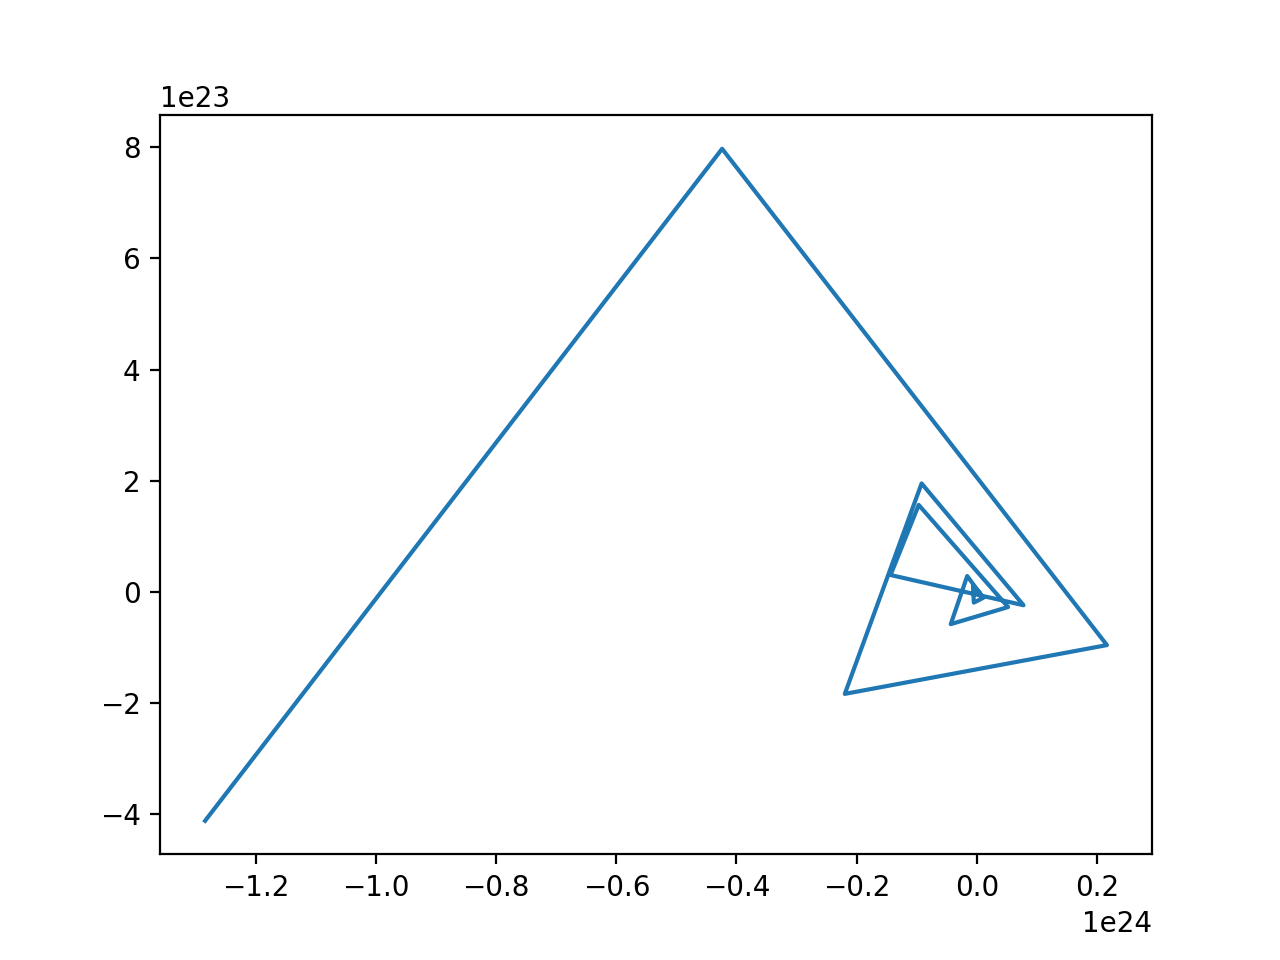

In [46]:
ai = sim.agents[0]
tr = np.vstack( ai.traj )

plt.figure()
plt.plot(tr[:,0], tr[:,1]) 
plt.show()

<IPython.core.display.Javascript object>


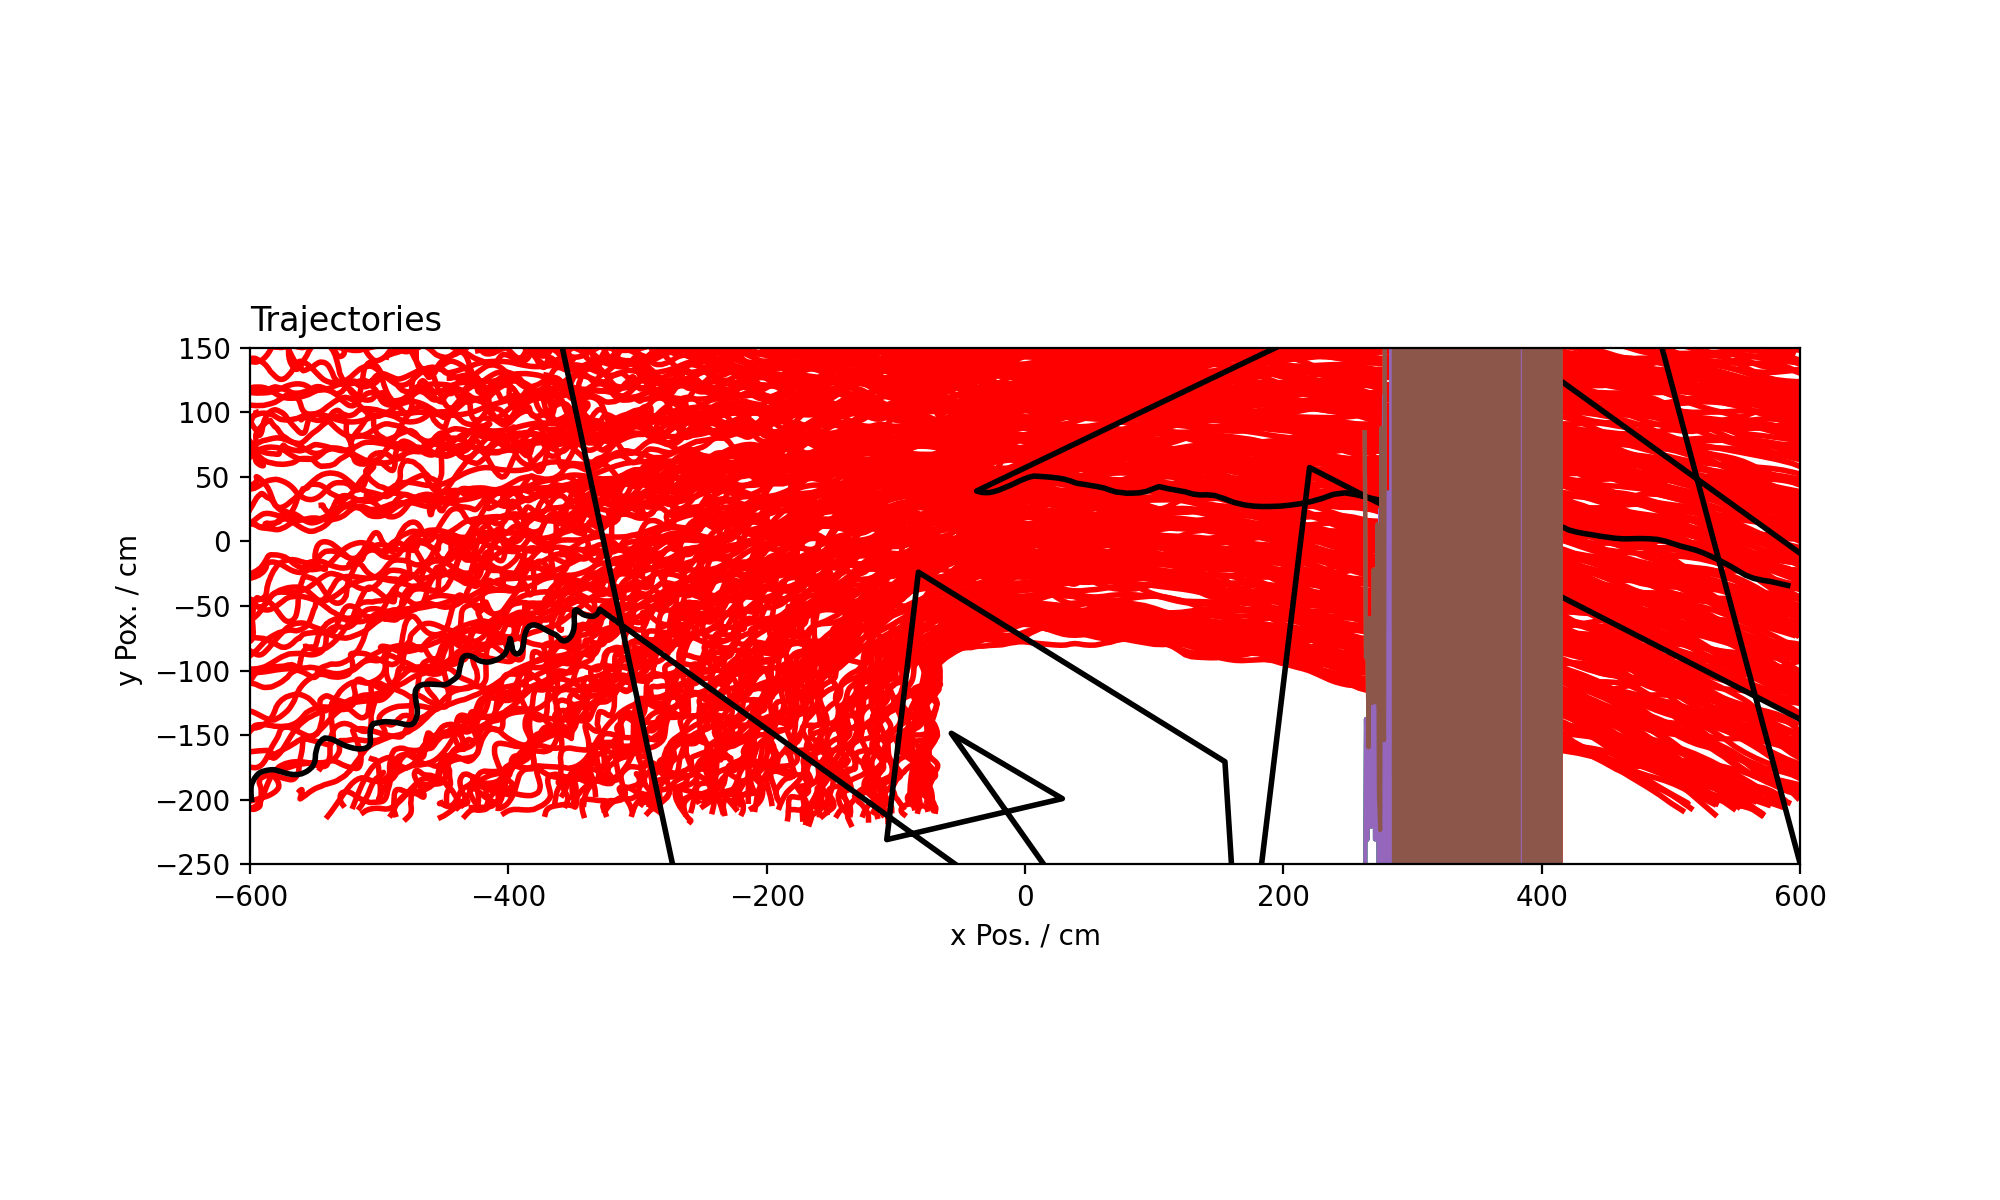

In [28]:
dp = DataLoader(None)
dp.copy(sim.ds)
dp.append_person(test_person, frames_o, pos_vel_o[:,:2], vel=pos_vel_o[:,2:] )

plotTraj(dp,  boundaries=[-600, 600, -250, 150],
         people=None,
         ai=[ 100+test_person],
         legend=False,
         title="Trajectories",
         path="trajectories.png",
         save=False)

<IPython.core.display.Javascript object>


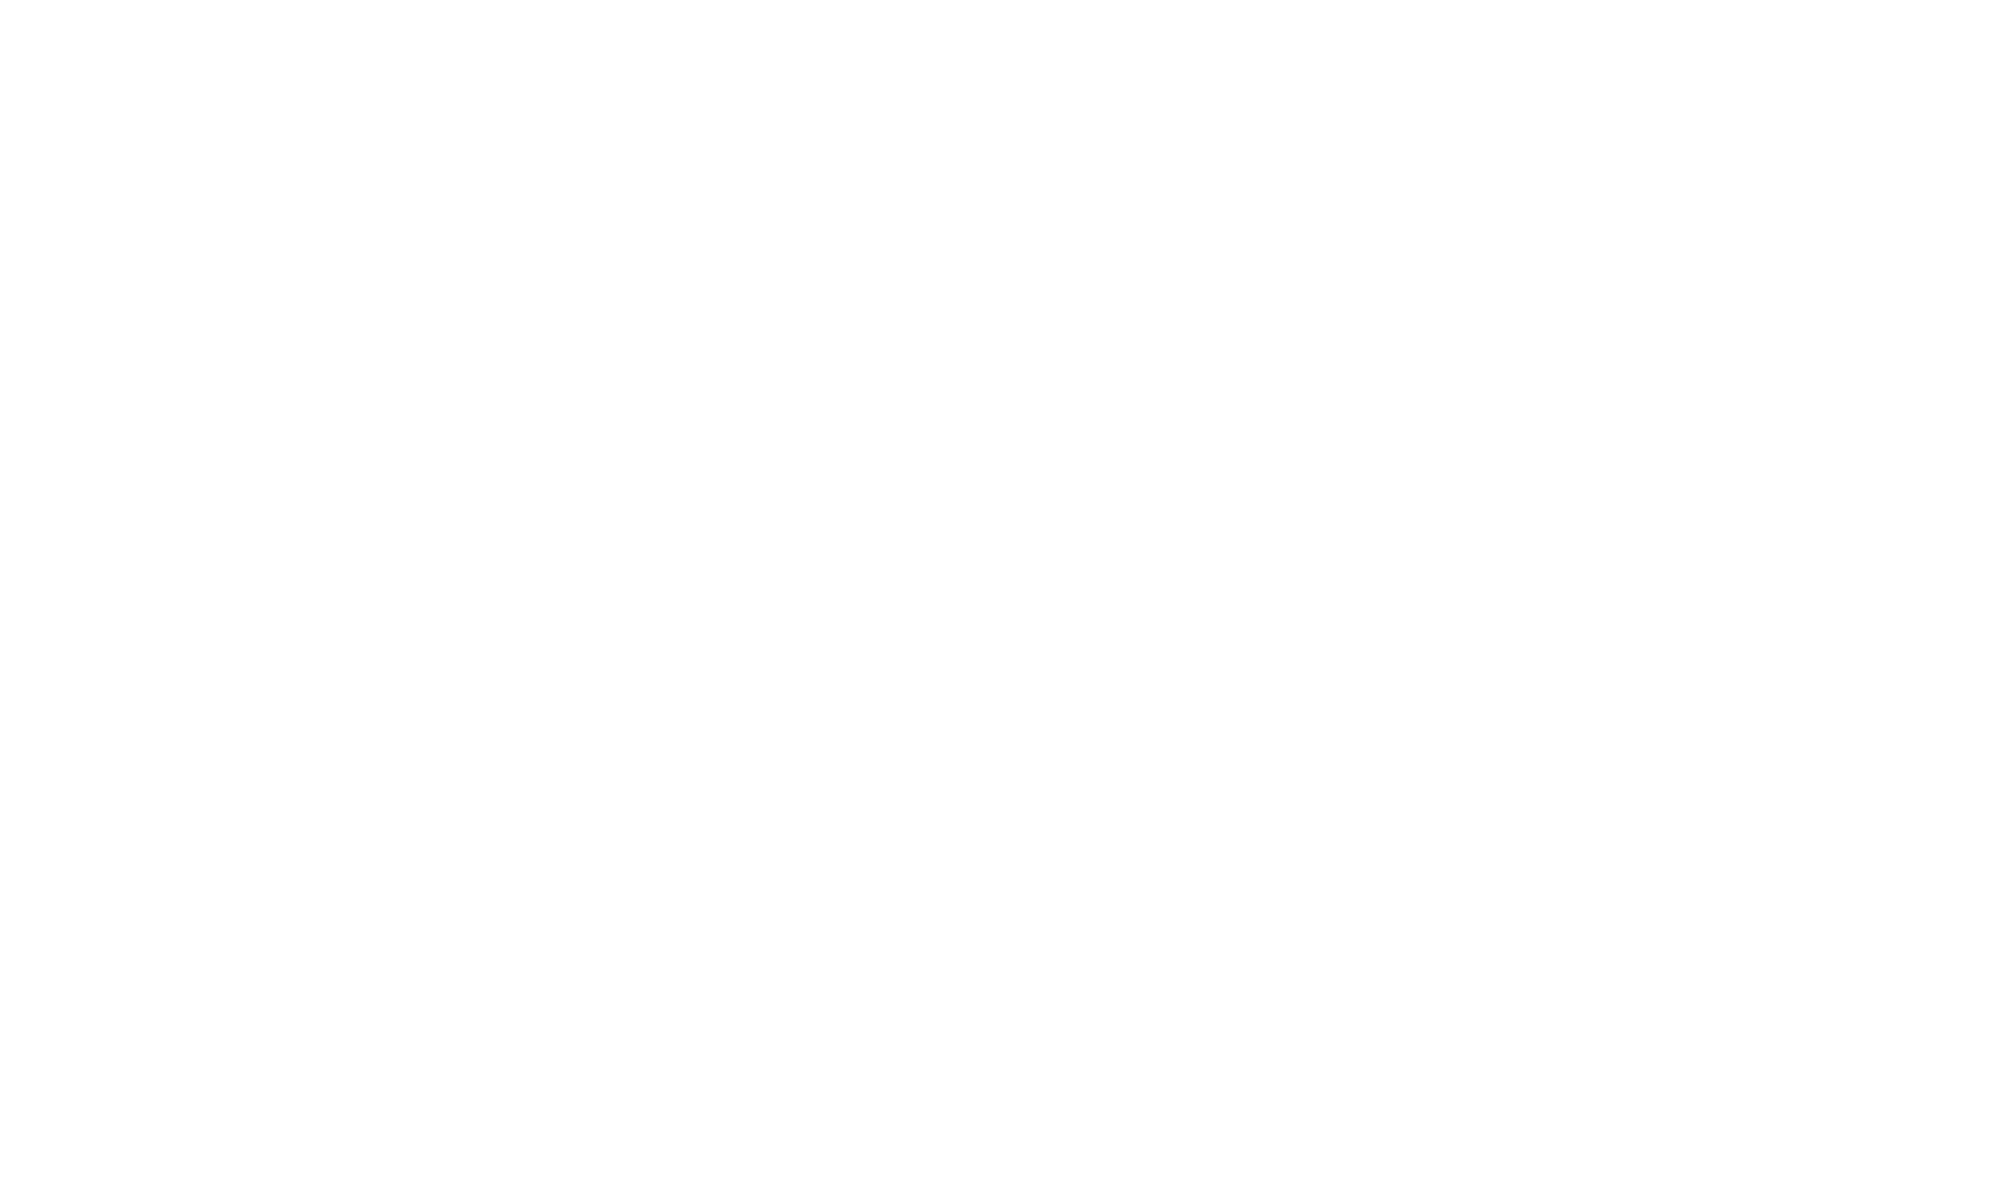

In [29]:
ani = animateLoc(dp, frame_start=frames_o[0], frame_stop=frames_o[-1],ai=[100+test_person],
             boundaries=[-800, 600, -200, 400], step=5, fps=16, title="ululululu", save=False)
display(ani)

In [ ]:
animatePreview(dp, boundaries=[-600, 600, -250, 150], step=5)

In [ ]:
ani = animateTraj(dp, frame_start=frames[0], frame_stop=frames[-1], boundaries=[-600, 600, -250, 150], step=1, fps=16, title="Trajectory Animation")
ani

In [ ]:
id_s, trajs = da.get_trajectories(number_nei)

In [ ]:



id = 15
mask = np.zeros_like(id_s, dtype=np.bool)




j, traj = id_s[id], trajs[id]
   
print(j)

frames, pos_vel =da.person(j) 

frames, _ = da.grab_roi(frames, pos_vel )



for i in range(len(traj)-1):
    print(traj[i], traj[i].shape)
    x_sim = torch.from_numpy(traj[i]).to(device)
    
    
    
    y_sim = model(x_sim)
    
    agent.step(traj[i])
    
    v_sim = (y_sim[:2]-x_sim[:2])/FPS
    traj[i+1, :2] = y_sim.cpu().detach().numpy()
    traj[i+1, 2:4] = v_sim.cpu().detach().numpy()



da.append_person(100+j,frames,  traj[:,:2])

In [ ]:
animatePreview(da, boundaries=[-600, 600, -250, 150], step=10)

In [ ]:
plotTraj(da,  boundaries=[-600, 600, -250, 150],
         people=None,
         ai=[20, 120],
         legend=False,
         title="Trajectories",
         path="trajectories.png",
         save=False)

In [ ]:
torch.save(model.state_dict(), "model.dat")

In [ ]:
ani = animateTraj(da, frame_start=220, frame_stop=370, boundaries=[-600, 600, -250, 150], step=5, fps=16, title="Trajectory Animation")
ani

In [ ]:
np.concatenate ([[1,2,3],[0],[5,6]])

In [ ]:
class Model(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.model = torch.nn.ModuleDict({
            'lstm': torch.nn.LSTM(
                input_size=D_in,    # 45, see the data definition
                hidden_size=l_o,  # Can vary
            ),
            'linear1': torch.nn.Linear(
                in_features=l_o,
                out_features=D_out)
        })
        
    def forward(self, x):

        # From [batches, seqs, seq len, features]
        # to [seq len, batch data, features]
        x = x.view(x_seq_len, -1, x_features)
       
        # Data is fed to the LSTM
        out, _ = self.model['lstm'](x)
        

        # From [seq len, batch, num_directions * hidden_size]
        # to [batches, seqs, seq_len,prediction]
        out = out.view(x_batches, x_seqs, x_seq_len, -1)
      

        # Data is fed to the Linear layer
        out = self.model['linear1'](out)
       

        # The prediction utilizing the whole sequence is the last one
        y_pred = out[:, :, -1].unsqueeze(-1)
       

        return y_pred


model = Model()